In [1]:
### imports
import os
import sys
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d as inter
from math import exp, pow, sqrt, ceil, log
from IPython.display import HTML
from tqdm import tqdm_notebook as tqdm
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
### my functions
def distribution1(M, x, y, x_avr, y_avr, x_scale, y_scale):
    return exp(-pow(((x-x_avr)/x_scale), M))*exp(-pow(((y-y_avr)/y_scale), M))

def distribution2(M, x, x_avr, x_scale):
    return exp(-pow(((x-x_avr)/x_scale), M))

def minmax(x, prevv, currr, nextt, add):
    maxx = max(prevv, currr, nextt)+add
    minn = min(prevv, currr, nextt)+add
    if x > maxx:
        return maxx
    if x < minn:
        return minn
    return x

In [3]:
### exact solution
def exact_solution(h_l, u_l, h_r, u_r, grav):
    # Compute left and right sound speeds
    c_l = np.sqrt(grav*h_l)
    c_r = np.sqrt(grav*h_r)

    # Check whether the 1-wave is a shock or rarefaction
    def phi_l(h):
        if h >= h_l:
            return (h_l*u_l + (h-h_l)*(u_l-np.sqrt(grav*h/2*(1 + h/h_l))))/h
        else:
            return u_l + 2*(np.sqrt(grav*h_l) - np.sqrt(grav*np.maximum(h, 0)))

    # Check whether the 2-wave is a shock or rarefaction
    def phi_r(h):
        if h >= h_r:
            return (h_r*u_r + (h-h_r)*(u_r+np.sqrt(grav*h/2*(1 + h/h_r))))/h
        else:
            return u_r - 2*(np.sqrt(grav*h_r) - np.sqrt(grav*np.maximum(h, 0)))

    ws = np.zeros(4)

    dry_velocity_l = u_l + 2*np.sqrt(grav*h_l)
    dry_velocity_r = u_r - 2*np.sqrt(grav*h_r)
    if dry_velocity_l < dry_velocity_r:
        # Dry middle state
        h_m = 0
        # This is a bit arbitrary:
        u_m = 0*0.5*(dry_velocity_l + dry_velocity_r)
        hu_m = u_m * h_m
        ws[0] = u_l - c_l
        ws[1] = dry_velocity_l
        ws[2] = dry_velocity_r
        ws[3] = u_r + c_r

    elif h_l == 0:
        # Dry left state; 2-rarefaction only
        h_m = 0
        u_m = dry_velocity_r
        hu_m = u_m * h_m
        ws[0] = 0
        ws[1] = 0
        ws[2] = dry_velocity_r
        ws[3] = u_r + c_r

    elif h_r == 0:
        # Dry right state; 1-rarefaction only
        h_m = 0
        u_m = dry_velocity_l
        hu_m = u_m * h_m
        ws[0] = u_l - c_l
        ws[1] = dry_velocity_l
        ws[2] = 0
        ws[3] = 0

    else:
        def phi(h): return phi_l(h)-phi_r(h)
        # Compute middle state h, u by finding curve intersection
        guess = ((u_l-u_r)/4 + np.sqrt(grav)*(np.sqrt(h_l)+np.sqrt(h_r))/2)**2./grav
        h_m, _, ier, msg = fsolve(phi, guess, full_output=True, xtol=1.e-14)
        # For strong rarefactions, sometimes fsolve needs help
        if ier != 1:
            guess = ((u_l-u_r)/4 + np.sqrt(grav)*(np.sqrt(h_l)+np.sqrt(h_r))/2)**2./grav
            h_m, _, ier, msg = fsolve(
                phi, guess, full_output=True, factor=0.1, xtol=1.e-10)
            # This should not happen:
            if ier != 1:
                print('Warning: fsolve did not converge.')
                print(msg)
        u_m = phi_l(h_m)
        hu_m = u_m * h_m

        hu_l = h_l * u_l
        hu_r = h_r * u_r

        # Find shock and rarefaction waves speeds
        if h_m > h_l:
            ws[0] = (hu_l - hu_m) / (h_l - h_m)
            ws[1] = ws[0]
        else:
            c_m = np.sqrt(grav * h_m)
            ws[0] = u_l - c_l
            ws[1] = u_m - c_m

        if h_m > h_r:
            ws[2] = (hu_r - hu_m) / (h_r - h_m)
            ws[3] = ws[2]
        else:
            c_m = np.sqrt(grav * h_m)
            ws[2] = u_m + c_m
            ws[3] = u_r + c_r

    # Find solution inside rarefaction waves
    def raref1(xi):
        R = u_l + 2*np.sqrt(grav*h_l)
        h = ((R - xi)**2 / (9*grav))
        u = (xi + np.sqrt(grav*h))
        return h, u

    def raref2(xi):
        Q = u_r - 2*np.sqrt(grav*h_r)
        h = ((Q - xi)**2 / (9*grav))
        u = (xi - np.sqrt(grav*h))
        return h, u

    def reval(xi):
        """Function that evaluates the Riemann solution for arbitrary xi = x/t.
        """
        rar1 = raref1(xi)
        rar2 = raref2(xi)
        h_out = (xi <= ws[0])*h_l + \
                (xi > ws[0])*(xi <= ws[1])*rar1[0] + \
                (xi > ws[1])*(xi <= ws[2])*h_m +  \
                (xi > ws[2])*(xi <= ws[3])*rar2[0] +  \
                (xi > ws[3])*h_r
        u_out = (xi <= ws[0])*u_l + \
                (xi > ws[0])*(xi <= ws[1])*rar1[1] + \
                (xi > ws[1])*(xi <= ws[2])*u_m +  \
                (xi > ws[2])*(xi <= ws[3])*rar2[1] +  \
                (xi > ws[3])*u_r
        return h_out, u_out

    return reval

Шагов по времмени  401
Размер неравномерной сетки  50  X  1
Размер расширенной  неравномерной сетки  101  X  3
Размер равномерной сетки  100.0  X  1
Размер расширенной  равномерной сетки  201.0  X  3


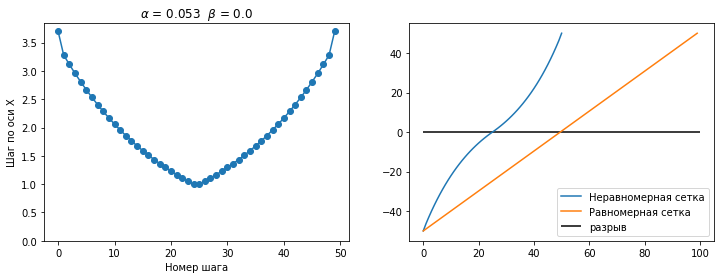

In [24]:
### global parameters
q = 1
total_time = 4  # time of simulation
dt = 0.01/q  # time step
X1 = -50  # left X limit
X2 = -X1 # right X limit
dx = 1/q  # X-axis default step
Y1 = 0  # left X limit
Y2 = 1  # right X limit
dy = 1  # Y-axis default step
hmin = 0  # lower height limit
hmax = 10  # upper height limit
dry_bed = 0  # height condition for dry bed
g = 10  # standard gravity constant
# split initial parameters
H_l = hmin + (hmax-hmin)*0.8
H_r = hmin + (hmax-hmin)*0.2
u_l = 0
u_r = 0
v_l = 0
v_r = 0
rcs = 0.5  # relative coorinate of the split
alpha = 0.053   # multiplying part of the grid step
beta  = 0.00 # additive part of the grid step
k1 = 1 + alpha
k2 = dx*beta


### mesh parameters
# non-uniform x-axis grid
DX = X2-X1
x_ = np.array([X1+rcs*DX])
step = dx
while (x_[-1] < X2-step/2):
    x_ = np.append(x_, [x_[-1]+step/2, x_[-1]+step])
    step = step * k1 + k2
x_[-1] = X2
x_[-2] = (x_[-1] + x_[-3])/2
step = dx
while (x_[0] > X1+step/2):
    x_ = np.append([x_[0]-step, x_[0]-step/2], x_)
    step = step * k1 + k2
x_[0] = X1
x_[1] = (x_[0] + x_[2])/2
N_x = x_.size
Nx = int((N_x-1)/2)
# the rest grid parameters
N_ex = 1000 # number of exact solution nodes
Nt = int(total_time/dt)+1 #number of time layers
# uniform x-axis grid
DY = Y2-Y1
Ny = int(DY/dy)
N_y = 2*Ny+1
mid_y = (N_y//2)-(N_y//2) % 2+1  # number of middle y-axis element

# mesh info
print("Шагов по времмени ", Nt)
print("Размер неравномерной сетки ", Nx, " X ", Ny)
print("Размер расширенной  неравномерной сетки ", N_x, " X ", N_y)
print("Размер равномерной сетки ", DX//dx, " X ", Ny)
print("Размер расширенной  равномерной сетки ", 2*DX//dx+1, " X ", N_y)
# print("CFL = ", round(cfl, 4))
fig1, (ax4, ax5) = plt.subplots(1, 2, figsize=(12, 4))
ax4.plot(x_[2::2]-x_[:-2:2],'o-')
ax4.set_ylim(0,)
ax4.set_title(r'$\alpha$ = '+'{}'.format(round(alpha,4)) +r'  $\beta$ = '+'{}'.format(round(beta,4)))
ax4.set_xlabel('Номер шага')
ax4.set_ylabel('Шаг по оси X')
ax5.plot(x_[::2], label = 'Неравномерная сетка')
ax5.plot(np.linspace(X1, X2, int(DX/dx)), label=r'Равномерная сетка')
ax5.hlines(X1+rcs*DX, 0, int(DX/dx), label = 'разрыв')
ax5.legend()
plt.show()


In [5]:
### remaining arrays
t = np.linspace(0, total_time, Nt)
# x_ = np.linspace(X1, X2, N_x)
y_ = np.linspace(Y1, Y2, N_y)
x_x, y_y = np.meshgrid(x_, y_)
# for exact solution
x_ex = np.linspace(x_[1], x_[-2], N_ex)
H_ex = np.zeros(N_ex)
u_ex = np.zeros(N_ex)
# for bottom, water and speed of propagation
b = np.zeros((N_y, N_x))
H = np.zeros((N_y, N_x))
h = np.zeros((3, N_y, N_x))
u = np.zeros((3, N_y, N_x))
v = np.zeros((3, N_y, N_x))
c = np.zeros((2, N_y, N_x))
# invariants and eigenvalues for x-axis and y-axis
Rx = np.zeros((3, N_y, N_x))
Qx = np.zeros((3, N_y, N_x))
V = np.zeros((3, N_y, N_x))
lRx = np.zeros((N_y, N_x))
lQx = np.zeros((N_y, N_x))
lV = np.zeros((N_y, N_x))
Ry = np.zeros((3, N_y, N_x))
Qy = np.zeros((3, N_y, N_x))
U = np.zeros((3, N_y, N_x))
lRy = np.zeros((N_y, N_x))
lQy = np.zeros((N_y, N_x))
lU = np.zeros((N_y, N_x))
# base for an error storage array
Err = np.zeros((1,3))

In [6]:
### initial condition
for j in range(N_y):
    for i in range(N_x):
        if (x_[i] < int(X1+rcs*DX)):
            H[j, i] = H_l
            u[0, j, i] = u_l
            v[0, j, i] = v_l
        elif(x_[i] == int(X1+rcs*DX)):
            H[j, i] = (H_l + H_r)/2
            u[0, j, i] = (u_l + u_r)/2
            v[0, j, i] = (v_l + v_r)/2
        else:
            H[j, i] = H_r
            u[0, j, i] = u_r
            v[0, j, i] = v_r
        b[j, i] = hmin
#         some 2-d distribution
#         H[j, i] += 0.6*(hmax-hmin)*distribution1(6, x_[i], y_[j], DX*4/5, DY*1/2, DY*1/10, DY*1/10)
#         H[j, i] += distribution1(2, x_[i], y_[j], DX*1/5, DY*1/2, DX*1/16, DY*1/6)
#         H[j, i] += 0.5*distribution2(2, x_[i], DX*1/6, DX*1/12)
        
#         tilted bottom
#         b[j, i] += 4*i/N_x

#         book test
#         H[j,i]=hmax-4;
#         u[0,j,i]=5*(x_[i]>1)*(x_[i]<5)
#         b[j,i] = 0*(x_[i]<1)+2.6*(x_[i]-1)*(x_[i]>1)*(x_[i]<4.46154)+(x_[i]>4.46154)*9
        
        
        if (H[j, i] <= b[j, i] + dry_bed):
            H[j, i] = b[j, i] + dry_bed
        h[:, j, i] = H[j, i] - b[j, i]
for i in range(N_ex):
    if (i < int(rcs*N_ex)):
        H_ex[i] = H_l
        u_ex[i] = u_l
    else:
        H_ex[i] = H_r
        u_ex[i] = u_r

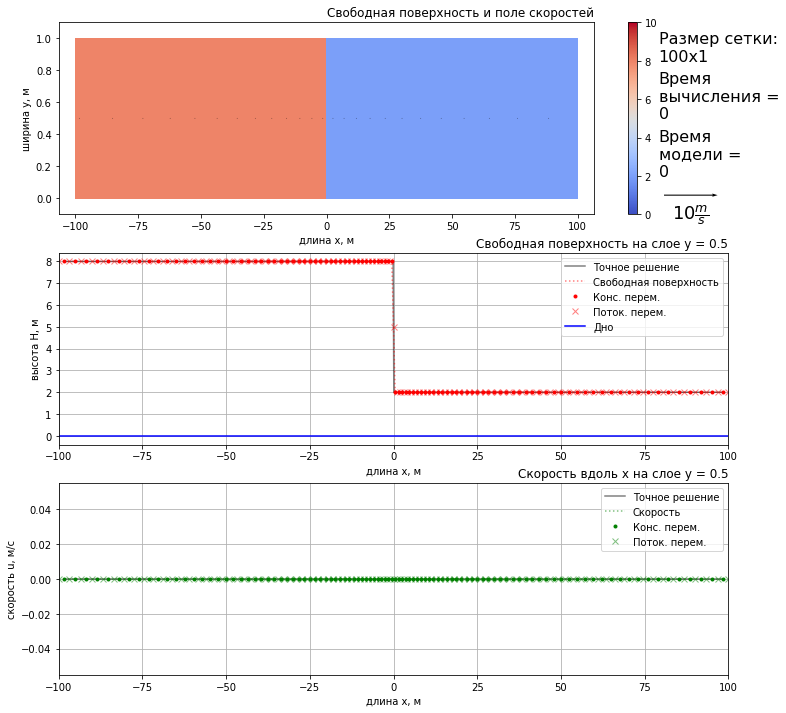

In [7]:
### plots initialization
fig, (ax0, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
frames = []
ax0.set_xlim(X1-DX/30, X2+DX/30)
ax0.set_ylim(Y1-DY/10, Y2+DY/10)
ax2.set_xlim(X1, X2)
ax3.set_xlim(X1, X2)
ax0.grid(True)
ax2.grid(True)
ax3.grid(True)
ax0.set_title('Свободная поверхность и поле скоростей', loc='right')
ax0.set_xlabel('длина x, м')
ax0.set_ylabel('ширина y, м')
ax2.set_title('Свободная поверхность на слое y = ' +
              str(y_[mid_y]), loc='right')
ax2.set_xlabel('длина x, м')
ax2.set_ylabel('высота H, м')
ax3.set_title('Скорость вдоль x на слое y = ' + str(y_[mid_y]), loc='right')
ax3.set_xlabel('длина x, м')
ax3.set_ylabel('скорость u, м/c')

q_r_x = 2*(Nx//30+1)  # quiver rarity for x axis
q_r_y = 2*(Ny//10+1)  # quiver rarity for y axis
q_s_x = (((N_x % q_r_x)//2)//2)*2+1 # quiver start for x axis
q_s_y = (((N_y % q_r_y)//2)//2)*2+1 # quiver start for x axis
wwidth = 0.002 # quiver key width
sscale = 100*ceil(sqrt((hmax-hmin)*g))/10 # quiver key scale
aalpha = 0.4 # quiver transparency (0 - more, 1 - less)

# first frame t =0
im0 = ax0.pcolormesh(x_[::2], y_[::2], H[1::2, 1::2],
                     cmap='coolwarm', vmin=hmin, vmax=hmax)
fig.colorbar(im0, ax=ax0)
im1 = ax0.quiver(x_[q_s_x::q_r_x], y_[q_s_y::q_r_y],
                 u[0, q_s_y::q_r_y, q_s_x::q_r_x], v[0, q_s_y::q_r_y, q_s_x::q_r_x],
                 width=wwidth, scale=sscale, alpha=aalpha)
ax0.quiverkey(im1, 1.18, 0.10, ceil(sqrt((hmax-hmin)*g)),
              '{}'.format(ceil(sqrt((hmax-hmin)*g)))+r'$ \frac{m}{s}$',
              fontproperties={'size': 18}, labelpos='S', alpha=1)
title0 = ax0.text(1.12, 0.8, "Размер сетки:\n{}x{}".format(Nx,Ny),
                  size=16, transform=ax0.transAxes)
title1 = ax0.text(1.12, 0.5, "Время\nвычисления =\n{}".format(0),
                  size=16, transform=ax0.transAxes)
title2 = ax0.text(1.12, 0.2, "Время\nмодели =\n{}".format(0),
                  size=16, transform=ax0.transAxes)

im20, = ax2.plot(x_ex, H_ex, 'k', label='Точное решение', alpha=0.5)
im21, = ax2.plot(x_[1::2], H[mid_y, 1::2], 'r:', label='Свободная поверхность', alpha=0.5)
im22, = ax2.plot(x_[1::2], H[mid_y, 1::2], 'r.', label='Конс. перем.')
im23, = ax2.plot(x_[0::2], H[mid_y, 0::2], 'rx',label='Поток. перем.', alpha=0.5)
im24, = ax2.plot(x_, b[mid_y, ::], 'b', label='Дно')
ax2.legend()
im30, = ax3.plot(x_ex, u_ex, 'k', label='Точное решение', alpha=0.5)
im31, = ax3.plot(x_[1::2], u[0, mid_y, 1::2], 'g:', label='Скорость', alpha=0.5)
im32, = ax3.plot(x_[1::2], u[0, mid_y, 1::2], 'g.', label='Конс. перем.')
im33, = ax3.plot(x_[0::2], u[0, mid_y, 0::2], 'gx',label='Поток. перем.', alpha=0.5)
ax3.legend()
frames.append([title0, title1, title2, im0, im1, im20, im21,
               im22, im23, im24, im30, im31, im32, im33])
# plt.close()

In [8]:
### Main computations
# estimated value of Courant–Friedrichs–Lewy constant
cfl = sqrt((hmax-hmin)*g)*dt/dx
# calculating of the exact solution
reval = exact_solution(H_l, u_l, H_r, u_r, g)
Err = np.zeros((1,3))
# for calculating the running full time of the modeling part
total_modeling_time = 0
# modeling
for n in tqdm(range(1, Nt+1)):
    start_time = time.time() # fixing the start of the algorithm
#     step 1
    for j in range(1, N_y-1, 2):
        for i in range(1, N_x-1, 2):
            h[1, j, i] = (h[0, j, i] -
                          dt/2*((h[0, j, i+1]*u[0, j, i+1] - h[0, j, i-1]*u[0, j, i-1])/(x_[i+1] - x_[i-1]) +
                                (h[0, j+1, i]*v[0, j+1, i] - h[0, j-1, i]*v[0, j-1, i])/(y_[j+1] - y_[j-1])))
            if (h[1, j, i] < dry_bed):
                print('dry bed on 1 step', str(h[1, j, i].round(3)))
                h[1, j, i] = dry_bed
                u[1, j, i] = 0
                v[1, j, i] = 0
            else:   
                u[1, j, i] = (h[0, j, i]*u[0, j, i] -
                              dt/2*((h[0, j, i+1]*u[0, j, i+1]*u[0, j, i+1] - h[0, j, i-1]*u[0, j, i-1]*u[0, j, i-1])/
                                    (x_[i+1] - x_[i-1]) +
                                    (h[0, j+1, i]*u[0, j+1, i]*v[0, j+1, i] - h[0, j-1, i]*u[0, j-1, i]*v[0, j-1, i])/
                                    (y_[j+1] - y_[j-1]) +
                                    g/2*(h[0, j, i+1]**2 - h[0, j, i-1]**2)/(x_[i+1] - x_[i-1]) +
                                    g*h[0, j, i]*(b[j, i+1] - b[j, i-1])/(x_[i+1] - x_[i-1])))/h[1, j, i]

                v[1, j, i] = (h[0, j, i]*v[0, j, i] -
                              dt/2*((h[0, j, i+1]*u[0, j, i+1]*v[0, j, i+1] - h[0, j, i-1]*u[0, j, i-1]*v[0, j, i-1])/
                                    (x_[i+1] - x_[i-1]) +
                                    (h[0, j+1, i]*v[0, j+1, i]*v[0, j+1, i] - h[0, j-1, i]*v[0, j-1, i]*v[0, j-1, i])/
                                    (y_[j+1] - y_[j-1]) +
                                    g/2*(h[0, j+1, i]**2 - h[0, j-1, i]**2)/(y_[j+1] - y_[j-1]) +
                                    g*h[0, j, i]*(b[j+1, i] - b[j-1, i])/(y_[j+1] - y_[j-1])))/h[1, j, i]

#     step 2
#     calculating speed of sound
    for j in range(N_y):
        for i in range(N_x):
            c[0, j, i] = sqrt(g*h[0, j, i])
            c[1, j, i] = sqrt(g*h[1, j, i])
            
#     calculating x characteristics
    for j in range(N_y):
        for i in range(N_x):
            Rx[0, j, i] = u[0, j, i]+2*c[0, j, i]
            Qx[0, j, i] = u[0, j, i]-2*c[0, j, i]
            V[0, j, i] = v[0, j, i]
            
            Rx[1, j, i] = u[1, j, i]+2*c[1, j, i]
            Qx[1, j, i] = u[1, j, i]-2*c[1, j, i]
            V[1, j, i] = v[1, j, i]

            lRx[j, i] = u[1, j, i]+c[1, j, i]
            lQx[j, i] = u[1, j, i]-c[1, j, i]
            lV[j, i] = v[1, j, i]
#     along the x axis
    for j in range(1, N_y-1, 2):
        for i in range(1, N_x-3, 2):
#             Rx            
            if (lRx[j][i]*lRx[j][i+2] < 0):
                print('sound point Rx', i, j)
                Rx[2, j, i+1] = Rx[0, j, i+1]
            else:
                if (lRx[j][i]+lRx[j][i+2] > 0):
                    G = (-g/c[0, j, i]*((h[0, j+1, i]*v[0, j+1, i] - h[0, j-1, i]*v[0, j-1, i])/(y_[j+1] - y_[j-1])) -
                         g*(b[j, i+1] - b[j, i-1])/(x_[i+1] - x_[i-1]) -
                         v[0, j, i]*((u[0, j+1, i] - u[0, j-1, i])/(y_[j+1] - y_[j-1])))
                    Rx[2, j, i+1] = minmax(2*Rx[1, j, i]-Rx[0, j, i-1],
                                          Rx[0, j, i-1], Rx[0, j, i], Rx[0, j, i+1], dt*G)
                else:
                    G = (-g/c[0, j, i+2]*((h[0, j+1, i+2]*v[0, j+1, i+2] - h[0, j-1, i+2]*v[0, j-1, i+2])/(y_[j+1] - y_[j-1])) -
                         g*((b[j, i+3] - b[j, i+1])/(x_[i+3] - x_[i+1])) -
                         v[0, j, i+2]*((u[0, j+1, i+2] - u[0, j-1, i+2])/(y_[j+1] - y_[j-1])))
                    Rx[2, j, i+1] = minmax(2*Rx[1, j, i+2]-Rx[0, j, i+3],
                                          Rx[0, j, i+3], Rx[0, j, i+2], Rx[0, j, i+1], dt*G)
#             Qx
            if (lQx[j][i]*lQx[j][i+2] < 0):
                print('sound point Qx', i, j)
                Qx[2, j, i+1] = Qx[0, j, i+1]
            else:
                if (lQx[j][i]+lQx[j][i+2] > 0):
                    G = (g/c[0, j, i]*((h[0, j+1, i]*v[0, j+1, i] - h[0, j-1, i]*v[0, j-1, i])/(y_[j+1] - y_[j-1])) -
                         g*((b[j, i+1] - b[j, i-1])/(x_[i+1] - x_[i-1])) -
                         v[0, j, i]*((u[0, j+1, i] - u[0, j-1, i])/(y_[j+1] - y_[j-1])))
                    Qx[2, j, i+1] = minmax(2*Qx[1, j, i]-Qx[0, j, i-1],
                                          Qx[0, j, i-1], Qx[0, j, i], Qx[0, j, i+1], dt*G)
                else:
                    G = (g/c[0, j, i+2]*((h[0, j+1, i+2]*v[0, j+1, i+2] - h[0, j-1, i+2]*v[0, j-1, i+2])/(y_[j+1] - y_[j-1])) -
                         g*((b[j, i+3] - b[j, i+1])/(x_[i+3] - x_[i+1])) -
                         v[0, j, i+2]*((u[0, j+1, i+2] - u[0, j-1, i+2])/(y_[j+1] - y_[j-1])))
                    Qx[2, j, i+1] = minmax(2*Qx[1, j, i+2]-Qx[0, j, i+3],
                                          Qx[0, j, i+3], Qx[0, j, i+2], Qx[0, j, i+1], dt*G)
#             V
            if (lV[j][i]*lV[j][i+2] < 0):
#                 print('sound point V', i, j)
                Rx[2, j, i+1] = Rx[0, j, i+1]
            else:
                if (lV[j][i]+lV[j][i+2] > 0):
                    G = -(g*((b[j+1, i] - b[j-1, i])/(y_[j+1] - y_[j-1])) +
                          g*((h[0, j+1, i] - h[0, j-1, i])/(y_[j+1] - y_[j-1])) +
                          v[0, j, i]*((v[0, j+1, i] - v[0, j-1, i])/(y_[j+1] - y_[j-1])))
                    V[2, j, i+1] = minmax(2*V[1, j, i]-V[0, j, i-1],
                                          V[0, j, i-1], V[0, j, i], V[0, j, i+1], dt*G)
                else:
                    G = -(g*((b[j+1, i+2] - b[j-1, i+2])/(y_[j+1] - y_[j-1])) +
                          g*((h[0, j+1, i+2] - h[0, j-1, i+2])/(y_[j+1] - y_[j-1])) +
                          v[0, j, i+2]*((v[0, j+1, i+2] - v[0, j-1, i+2])/(y_[j+1] - y_[j-1])))
                    V[2, j, i+1] = minmax(2*V[1, j, i+2]-V[0, j, i+3],
                                          V[0, j, i+3], V[0, j, i+2], V[0, j, i+1], dt*G)       

            h[2, j, i+1] = 1/g/16*(Rx[2, j, i+1]-Qx[2, j, i+1])**2
            if (h[2, j, i+1] < dry_bed):
                print('dry bed on 2.1 step', str(h[2, j, i+1].round(3)))
                h[2, j, i+1] = dry_bed
                u[2, j, i+1] = 0
                v[2, j, i+1] = 0
            else:
                u[2, j, i+1] = 1/2*(Rx[2, j, i+1]+Qx[2, j, i+1])
                v[2, j, i+1] = V[2, j, i+1]
                
#     calculating y characteristics
    for j in range(N_y):
        for i in range(N_x):
            Ry[0, j, i] = v[0, j, i]+2*c[0, j, i]
            Qy[0, j, i] = v[0, j, i]-2*c[0, j, i]
            U[0, j, i] = u[0, j, i]

            Ry[1, j, i] = v[1, j, i]+2*c[1, j, i]
            Qy[1, j, i] = v[1, j, i]-2*c[1, j, i]
            U[1, j, i] = u[1, j, i]

            lRy[j, i] = v[1, j, i]+c[1, j, i]
            lQy[j, i] = v[1, j, i]-c[1, j, i]
            lU[j, i] = u[1, j, i]
#     along the y axis  
    for j in range(1, N_y-3, 2):
        for i in range(1, N_x-1, 2):
#             Ry
            if (lRy[j][i]*lRy[j+2][i] < 0):
                print('sound point Ry', i, j)
                Ry[2, j+1, i] = Ry[0, j+1, i]
            else:
                if (lRy[j][i]+lRy[j+2][i] > 0):
                    G = (-g/c[0, j, i]*((h[0, j, i+1]*u[0, j, i+1] - h[0, j, i-1]*u[0, j, i-1])/(x_[i+1] - x_[i-1])) -
                         g*(b[j+1, i] - b[j-1, i])/(y_[j+1] - y_[j-1]) -
                         u[0, j, i]*((v[0, j, i+1] - v[0, j, i-1])/(x_[i+1] - x_[i-1])))
                    Ry[2, j+1, i] = minmax(2*Ry[1, j, i]-Ry[0, j-1, i],
                                          Ry[0, j-1, i], Ry[0, j, i], Ry[0, j+1, i], dt*G)
                else:
                    G = (-g/c[0, j+2, i]*((h[0, j+2, i+1]*u[0, j+2, i+1] - h[0, j+2, i-1]*u[0, j+2, i-1])/(x_[i+1] - x_[i-1])) -
                         g*((b[j+3, i] - b[j+1, i])/(y_[j+3] - y_[j+1])) -
                         u[0, j+2, i]*((v[0, j+2, i+1] - v[0, j+2, i-1])/(x_[i+1] - x_[i-1])))
                    Ry[2, j+1, i] = minmax(2*Ry[1, j+2, i]-Ry[0, j+3, i],
                                          Ry[0, j+3, i], Ry[0, j+2, i], Ry[0, j+1, i], dt*G)
#             Qy
            if (lQy[j][i]*lQy[j+2][i] < 0):
                print('sound point Qy', i, j)
                Qy[2, j+1, i] = Qy[0, j+1, i]
            else:
                if (lQy[j][i]+lQy[j+2][i] > 0):
                    G = (g/c[0, j, i]*((h[0, j, i+1]*u[0, j, i+1] - h[0, j, i-1]*u[0, j, i-1])/(x_[i+1] - x_[i-1])) -
                         g*(b[j+1, i] - b[j-1, i])/(y_[j+1] - y_[j-1]) -
                         u[0, j, i]*((v[0, j, i+1] - v[0, j, i-1])/(x_[i+1] - x_[i-1])))
                    Qy[2, j+1, i] = minmax(2*Qy[1, j, i]-Qy[0, j-1, i],
                                          Qy[0, j-1, i], Qy[0, j, i], Qy[0, j+1, i], dt*G)
                else:
                    G = (g/c[0, j+2, i]*((h[0, j+2, i+1]*u[0, j+2, i+1] - h[0, j+2, i-1]*u[0, j+2, i-1])/(x_[i+1] - x_[i-1])) -
                         g*((b[j+3, i] - b[j+1, i])/(y_[j+3] - y_[j+1])) -
                         u[0, j+2, i]*((v[0, j+2, i+1] - v[0, j+2, i-1])/(x_[i+1] - x_[i-1])))
                    Qy[2, j+1, i] = minmax(2*Qy[1, j+2, i]-Qy[0, j+3, i],
                                          Qy[0, j+3, i], Qy[0, j+2, i], Qy[0, j+1, i], dt*G)
#             U
            if (lU[j][i]*lU[j+2][i] < 0):
                print('sound point U', i, j)
                U[2, j+1, i] = U[0, j+1, i]
            else:
                if (lV[j][i]+lV[j+2][i] > 0):
                    G = -(g*((b[j, i+1] - b[j, i-1])/(x_[i+1] - x_[i-1])) +
                          g*((h[0, j, i+1] - h[0, j, i-1])/(x_[i+1] - x_[i-1])) +
                          u[0, j, i]*((u[0, j, i+1] - u[0, j, i-1])/(x_[i+1] - x_[i-1])))
                    U[2, j+1, i] = minmax(2*U[1, j, i]-U[0, j-1, i],
                                          U[0, j-1, i], U[0, j, i], U[0, j+1, i], dt*G)
                else:
                    G = -(g*((b[j+2, i+1] - b[j+2, i-1])/(x_[i+1] - x_[i-1])) +
                          g*((h[0, j+2, i+1] - h[0, j+2, i-1])/(x_[i+1] - x_[i-1])) +
                          u[0, j+2, i]*((u[0, j+2, i+1] - u[0, j+2, i-1])/(x_[i+1] - x_[i-1])))
                    U[2, j+1, i] = minmax(2*U[1, j+2, i]-U[0, j+3, i],
                                          U[0, j+3, i], U[0, j+2, i], U[0, j+1, i], dt*G)   
            
            h[2, j+1, i] = 1/g/16*(Ry[2, j+1, i]-Qy[2, j+1, i])**2
            if (h[2, j+1, i] < dry_bed):
                print('dry bed on 2.2 step', str(h[2, j+1, i].round(3)))
                h[2, j+1, i] = dry_bed
                u[2, j+1, i] = 0
                v[2, j+1, i] = 0
            else:
                v[2, j+1, i] = 1/2*(Ry[2, j+1, i]+Qy[2, j+1, i])
                u[2, j+1, i] = U[2, j+1, i]

#     boundary condition
#         left
    h[2, :, 0] = h[2, :, 2]
    u[2, :, 0] = u[2, :, 2]
    v[2, :, 0] = v[2, :, 2]
#     u[2, :, 0] = u_l
#     v[2, :, 0] = v_l
#         right
    h[2, :, -1] = h[2, :, -3]
    u[2, :, -1] = u[2, :, -3]
    v[2, :, -1] = v[2, :, -3]
#     u[2, :, -1] = u_r
#     v[2, :, -1] = v_r
#         bottom
    h[2, 0, :] = h[2, 2, :] 
    u[2, 0, :] = u[2, 2, :]
    v[2, 0, :] = v[2, 2, :]
    
#         top
    h[2, -1, :] = h[2, -3, :]
    u[2, -1, :] = u[2, -3, :] 
    v[2, -1, :] = v[2, -3, :]
      
#     step 3
    for j in range(1, N_y-1, 2):
        for i in range(1, N_x-1, 2):
            h[2, j, i] = (h[1, j, i] -
                          dt/2*((h[2, j, i+1]*u[2, j, i+1] - h[2, j, i-1]*u[2, j, i-1])/(x_[i+1] - x_[i-1]) +
                                (h[2, j+1, i]*v[2, j+1, i] - h[2, j-1, i]*v[2, j-1, i])/(y_[j+1] - y_[j-1])))
            if (h[2, j, i] < dry_bed):
                print('dry bed on 3 step', str(h[2, j, i].round(3)))
                h[2, j, i] = dry_bed
                u[2, j, i] = 0
                v[2, j, i] = 0
            else:
                u[2, j, i] = (h[1, j, i]*u[1, j, i] -
                              dt/2*((h[2, j, i+1]*u[2, j, i+1]*u[2, j, i+1] - h[2, j, i-1]*u[2, j, i-1]*u[2, j, i-1])/
                                    (x_[i+1] - x_[i-1]) +
                                    (h[2, j+1, i]*u[2, j+1, i]*v[2, j+1, i] - h[2, j-1, i]*u[2, j-1, i]*v[2, j-1, i])/
                                    (y_[j+1] - y_[j-1]) +
                                    g/2*(h[2, j, i+1]**2 - h[2, j, i-1]**2)/(x_[i+1] - x_[i-1]) +
                                    g*h[2, j, i]*(b[j, i+1] - b[j, i-1])/(x_[i+1] - x_[i-1])))/h[2, j, i]
                v[2, j, i] = (h[1, j, i]*v[1, j, i] -
                              dt/2*((h[2, j, i+1]*u[2, j, i+1]*v[2, j, i+1] - h[2, j, i-1]*u[2, j, i-1]*v[2, j, i-1])/
                                    (x_[i+1] - x_[i-1]) +
                                    (h[2, j+1, i]*v[2, j+1, i]*v[2, j+1, i] - h[2, j-1, i]*v[2, j-1, i]*v[2, j-1, i])/
                                    (y_[j+1] - y_[j-1]) +
                                    g/2*(h[2, j+1, i]**2 - h[2, j-1, i]**2)/(y_[j+1] - y_[j-1]) +
                                    g*h[2, j, i]*(b[j+1, i] - b[j-1, i])/(y_[j+1] - y_[j-1])))/h[2, j, i]
    
    #     left
    h[2, :, 1] = h[2, :, 2]
    u[2, :, 1] = u[2, :, 2]
    v[2, :, 1] = v[2, :, 2]
#     u[2, :, 1] = u_l
#     v[2, :, 1] = v_l
#     right
    h[2, :, -2] = h[2, :, -3]
    u[2, :, -2] = u[2, :, -3]
    v[2, :, -2] = v[2, :, -3]
#     u[2, :, -2] = u_r
#     v[2, :, -2] = v_r

#     moving to a new layer
    h[0, :, :] = h[2, :, :]
    u[0, :, :] = u[2, :, :]
    v[0, :, :] = v[2, :, :]
    H = h[0, :, :] + b
    finish_time = time.time() # fixing the start of the algorithm
    total_modeling_time += finish_time - start_time
# counting error
    if n % (Nt//Nt) == 0:
        interp_h = inter(x_[1::2], H[mid_y, 1::2], kind='linear')
        interp_u = inter(x_[1::2], u[0, mid_y, 1::2], kind='linear')
        err = np.zeros((1,3))
        counts = N_ex
        H_ex, u_ex = reval((x_ex-(X1+rcs*DX))/(n*dt))
        H_ex += b[mid_y, 0]
        for i in range (N_ex):
                err[0,1] += abs(H_ex[i] - interp_h(x_ex[i]))*(DX/N_ex)
                err[0,2] += abs(u_ex[i] - interp_u(x_ex[i]))*(DX/N_ex)
        err[0,0] = n*dt
        Err=np.concatenate([Err, err])
#     capturing current state
    num_f = 10 #number of captured frames
    if n % (Nt//num_f) == 0:
        interp_h = inter(x_[1::2], H[mid_y, 1::2], kind='linear')
        H_ex, u_ex = reval((x_ex-(X1+rcs*DX))/(n*dt))
        H_ex += b[mid_y, 0]
        im0 = ax0.pcolormesh(x_[::2], y_[::2], H[1::2, 1::2],
                     cmap='coolwarm', vmin=hmin, vmax=hmax)
        im1 = ax0.quiver(x_[q_s_x::q_r_x], y_[q_s_y::q_r_y],
                         u[0, q_s_y::q_r_y, q_s_x::q_r_x], v[0, q_s_y::q_r_y, q_s_x::q_r_x],
                         width=wwidth, scale=sscale, alpha=aalpha)
        title0 = ax0.text(1.12, 0.8, "Размер сетки:\n{}x{}".format(Nx,Ny),
                          size=16, transform=ax0.transAxes)
        title1 = ax0.text(1.12, 0.5, "Время\nвычислений =\n{}".format(
                          round((total_modeling_time), 3)), size=16, transform=ax0.transAxes)
        title2 = ax0.text(1.12, 0.2, "Время\nмодели =\n{}".format(
                          round((n*dt), 3)), size=16, transform=ax0.transAxes)
        
        im20, = ax2.plot(x_ex, H_ex, 'k', label='Точное решение', alpha=0.5)
        im21, = ax2.plot(x_[1::2], H[mid_y, 1::2], 'r:', label='Свободная поверхность', alpha=0.5)
        im22, = ax2.plot(x_[1::2], H[mid_y, 1::2], 'r.', label='Конс. перем.')
        im23, = ax2.plot(x_[0::2], H[mid_y, 0::2], 'rx',label='Поток. перем.', alpha=0.5)
        im24, = ax2.plot(x_, b[mid_y,], 'b', label='Дно')

        im30, = ax3.plot(x_ex, u_ex, 'k', label='Точное решение', alpha=0.5)
        im31, = ax3.plot(x_[1::2], u[0, mid_y, 1::2], 'g:', label='Скорость', alpha=0.5)
        im32, = ax3.plot(x_[1::2], u[0, mid_y, 1::2], 'g.', label='Конс. перем.')
        im33, = ax3.plot(x_[0::2], u[0, mid_y, 0::2], 'gx',label='Поток. перем.', alpha=0.5)
        
        
        frames.append([title0, title1, title2, im0, im1, im20, im21,
                       im22, im23, im24, im30, im31, im32, im33])
finish_time = time.time()

Средняя  ошибка h =  2.49263
Средняя ошибка u =  4.59386


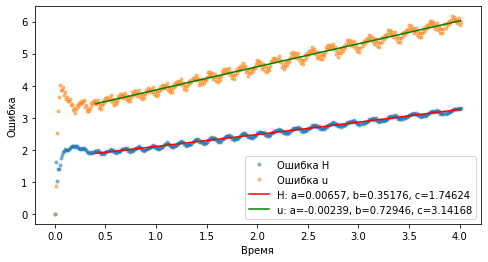

Шагов по времмени  401
Размер неравномерной сетки  100  X  1
Размер расширенной  неравномерной сетки  201  X  3
Размер равномерной сетки  200.0  X  1
Размер расширенной  равномерной сетки  401.0  X  3
CFL =  0.1


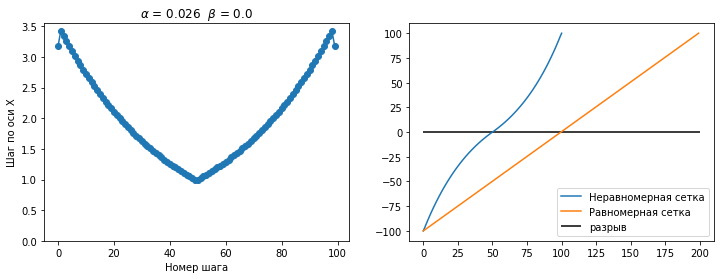

In [9]:
### some information 
# dependence of error from time
avr_h=np.average(Err.T[1])
avr_u=np.average(Err.T[2])
print("Средняя  ошибка h = ", round(avr_h, 5))
# print("Average relative h error = ", round(avr_h/(hmax-hmin)*100, 3), "%")
print("Средняя ошибка u = ", round(avr_u, 5))
fig2 = plt.figure(figsize=(8, 4))
plt.plot(Err.T[0], Err.T[1], '.', label='Ошибка H', alpha=0.5)
plt.plot(Err.T[0], Err.T[2], '.', label='Ошибка u', alpha=0.5)
def func(x, a, b, c):
    return a*x**2+b*x+c
ignored_part = int(Nt*0.1)
popt1, _ = curve_fit(func, Err.T[0, ignored_part::], Err.T[1, ignored_part::])
plt.plot(Err.T[0, ignored_part::], func(Err.T[0, ignored_part::], *popt1), 'r',
         label='H: a=%2.5f, b=%2.5f, c=%2.5f' % tuple(popt1))
popt2, _ = curve_fit(func, Err.T[0, ignored_part::], Err.T[2, ignored_part::])
plt.plot(Err.T[0, ignored_part::], func(Err.T[0, ignored_part::], *popt2), 'g',
         label='u: a=%2.5f, b=%2.5f, c=%2.5f' % tuple(popt2))
plt.xlabel('Время')
plt.ylabel('Ошибка')
plt.legend()
plt.show()
# mesh info
print("Шагов по времмени ", Nt)
print("Размер неравномерной сетки ", Nx, " X ", Ny)
print("Размер расширенной  неравномерной сетки ", N_x, " X ", N_y)
print("Размер равномерной сетки ", DX//dx, " X ", Ny)
print("Размер расширенной  равномерной сетки ", 2*DX//dx+1, " X ", N_y)
print("CFL = ", round(cfl, 4))
fig1, (ax4, ax5) = plt.subplots(1, 2, figsize=(12, 4))
ax4.plot(x_[2::2]-x_[:-2:2],'o-')
ax4.set_ylim(0,)
ax4.set_title(r'$\alpha$ = '+'{}'.format(round(alpha,4)) +r'  $\beta$ = '+'{}'.format(round(beta,4)))
ax4.set_xlabel('Номер шага')
ax4.set_ylabel('Шаг по оси X')
ax5.plot(x_[::2], label = 'Неравномерная сетка')
ax5.plot(np.linspace(X1, X2, int(DX/dx)), label=r'Равномерная сетка')
ax5.hlines(X1+rcs*DX, 0, int(DX/dx), label = 'разрыв')
ax5.legend()
plt.show()


In [10]:
### showing and saving animation
ani = animation.ArtistAnimation(fig, frames, interval=33.33, blit=True)
ani.save('animation.gif', writer='pillow', fps=5)
# ani.save('animation.mp4', writer='ffmpeg', fps=10)
HTML(ani.to_jshtml(fps=10))

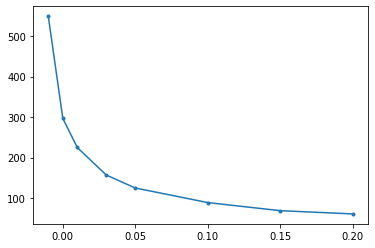

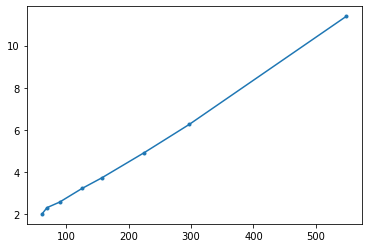

In [11]:
arr_a=np.array([0.99, 1., 1.01, 1.03, 1.05, 1.1, 1.15, 1.2])
arr_t=np.array([11.4, 6.25, 4.91, 3.71, 3.20, 2.55, 2.29, 1.99])
arr_n=np.array([549, 297, 225, 157, 125, 89, 69, 61])
plt.plot(arr_a-1, arr_n, '.-')
plt.show()
plt.show()
plt.plot(arr_n, arr_t, '.-')

plt.show()